In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np


#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------
def confidence_ellipse(mean_x, mean_y, cov, ax, n_std=0.1, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
#     if x.size != y.size:
#         raise ValueError("x and y must be the same size")

#     cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
#     mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
#     mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------
def vis(ax, box, ratio, padded_voxel_points, padded_voxel_points_teacher, cmap):
#     plt.clf()
# #     fig = plt.figure()
#     fig = plt.figure(figsize=(15,15))
#     ax = fig.add_axes([0,0,1,1])
    
    ax.imshow(
                np.max(padded_voxel_points, axis=2),
                cmap = cmap,
                alpha=1,
                zorder=1,
            )
    
    ax.imshow(
                np.max(padded_voxel_points_teacher, axis=2),
                cmap = "Blues",
                alpha=0.7,
                zorder=1,
            )
    

    # plot the gt boxes
    for k in range(box["groundtruth"].shape[0]):

        gt = np.concatenate((box["groundtruth"], np.expand_dims(box["groundtruth"][:, 0, :], axis=1)), axis=1)

        ax.plot(
            gt[k, :, 0]/0.25 + 128,
            gt[k, :, 1]/0.25 + 128 ,
            c="g",
            linewidth=3.0,
            zorder=20,
        )

    # plot the prediction boxes
    for k in range(box["mean"].shape[0]):

        corners = np.concatenate((box["mean"], np.expand_dims(box["mean"][:, 0, :], axis=1)), axis=1)

        ax.plot(
            corners[k, :, 0]/0.25 + 128,
            corners[k, :, 1]/0.25 + 128,
            c="r",
            linewidth=1,
            zorder=20,
        )

    # plot the covariance
    cov = box["covar"]

    for i in range(box["mean"].shape[0]):
        for j in range(box["mean"].shape[1]):
            mean_x = box["mean"][i,j,0]/0.25 + 128
            mean_y = box["mean"][i,j,1]/0.25 + 128
            confidence_ellipse(mean_x, mean_y, cov[i,j]/(0.25*0.25), ax, n_std=ratio, facecolor='tan', edgecolor='brown')
            
#     plt.axis('off')
#     plt.savefig('./all.svg')

In [3]:
def plot_results(agent, scene, frame):
    fig, axes = plt.subplots(1, 3, figsize=(50, 50))
    ax = axes.ravel()

    # ax[0].set_title('Original picture')
    # ax[0].imshow(image, cmap=plt.cm.gray)
    # ax[0].set_axis_off()

    # ax[1].set_title('Transformed picture')
    # # ax[1].imshow(chull, cmap=plt.cm.viridis) 
    # ax[1].imshow(chull, cmap=plt.cm.viridis)
    # ax[1].set_axis_off()

    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(agent) + "/" + str(scene) + "_" + str(frame)+ "/0.npy", allow_pickle=True).item()
    # print(gt_dict)
    indices = gt_dict["voxel_indices_0"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/disco_all/disco_dm/result"+ str(agent)  + "/" + str(scene) + "_" + str(frame) +".npy", allow_pickle=True).item()
    # box = np.load("/home/yml/Downloads/upperbound_all/upperbound_dm/result1/5_20.npy", allow_pickle=True).item()

    cmap = 'GnBu'
    # cmap = "PuBuGn"
    vis(ax[0], box, 2, padded_voxel_points, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    indices = gt_dict["voxel_indices_teacher"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)

    # specify the result path
    # box = np.load("/home/yml/Downloads/disco_all/disco_dm/result1/5_20.npy", allow_pickle=True).item()
    box = np.load("/home/yml/Downloads/upperbound_all/upperbound_dm/result"+ str(agent)  + "/" + str(scene) + "_" + str(frame) +".npy", allow_pickle=True).item()

    cmap = 'GnBu'
    # cmap = "PuBuGn"
    vis(ax[1], box, 2, padded_voxel_points, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    indices = gt_dict["voxel_indices_0"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/lowerbound_all/lowerbound_dm/result"+ str(agent)  + "/" + str(scene) + "_" + str(frame) +".npy", allow_pickle=True).item()
    # box = np.load("/home/yml/Downloads/upperbound_all/upperbound_dm/result1/5_20.npy", allow_pickle=True).item()

    cmap = 'GnBu'
    # cmap = "PuBuGn"
    vis(ax[2], box, 2, padded_voxel_points, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    ax[0].set_title('DiscoNet', fontsize=40)
    ax[1].set_title('Upperbound', fontsize=40)
    ax[2].set_title('Lowerbound', fontsize=40)
    
    ax[0].set_xlabel('X', fontsize=16)
    ax[0].set_ylabel('Y', fontsize=16)
    
    ax[0].set_xlim(0,256)
    ax[1].set_xlim(0,256)
    ax[2].set_xlim(0,256)
    
    ax[0].set_ylim(256,0)
    ax[1].set_ylim(256,0)
    ax[2].set_ylim(256,0)

    
    plt.savefig('./chull' + str(agent) + '_' + str(scene) + '_' + str(frame) + '.svg',bbox_inches='tight')

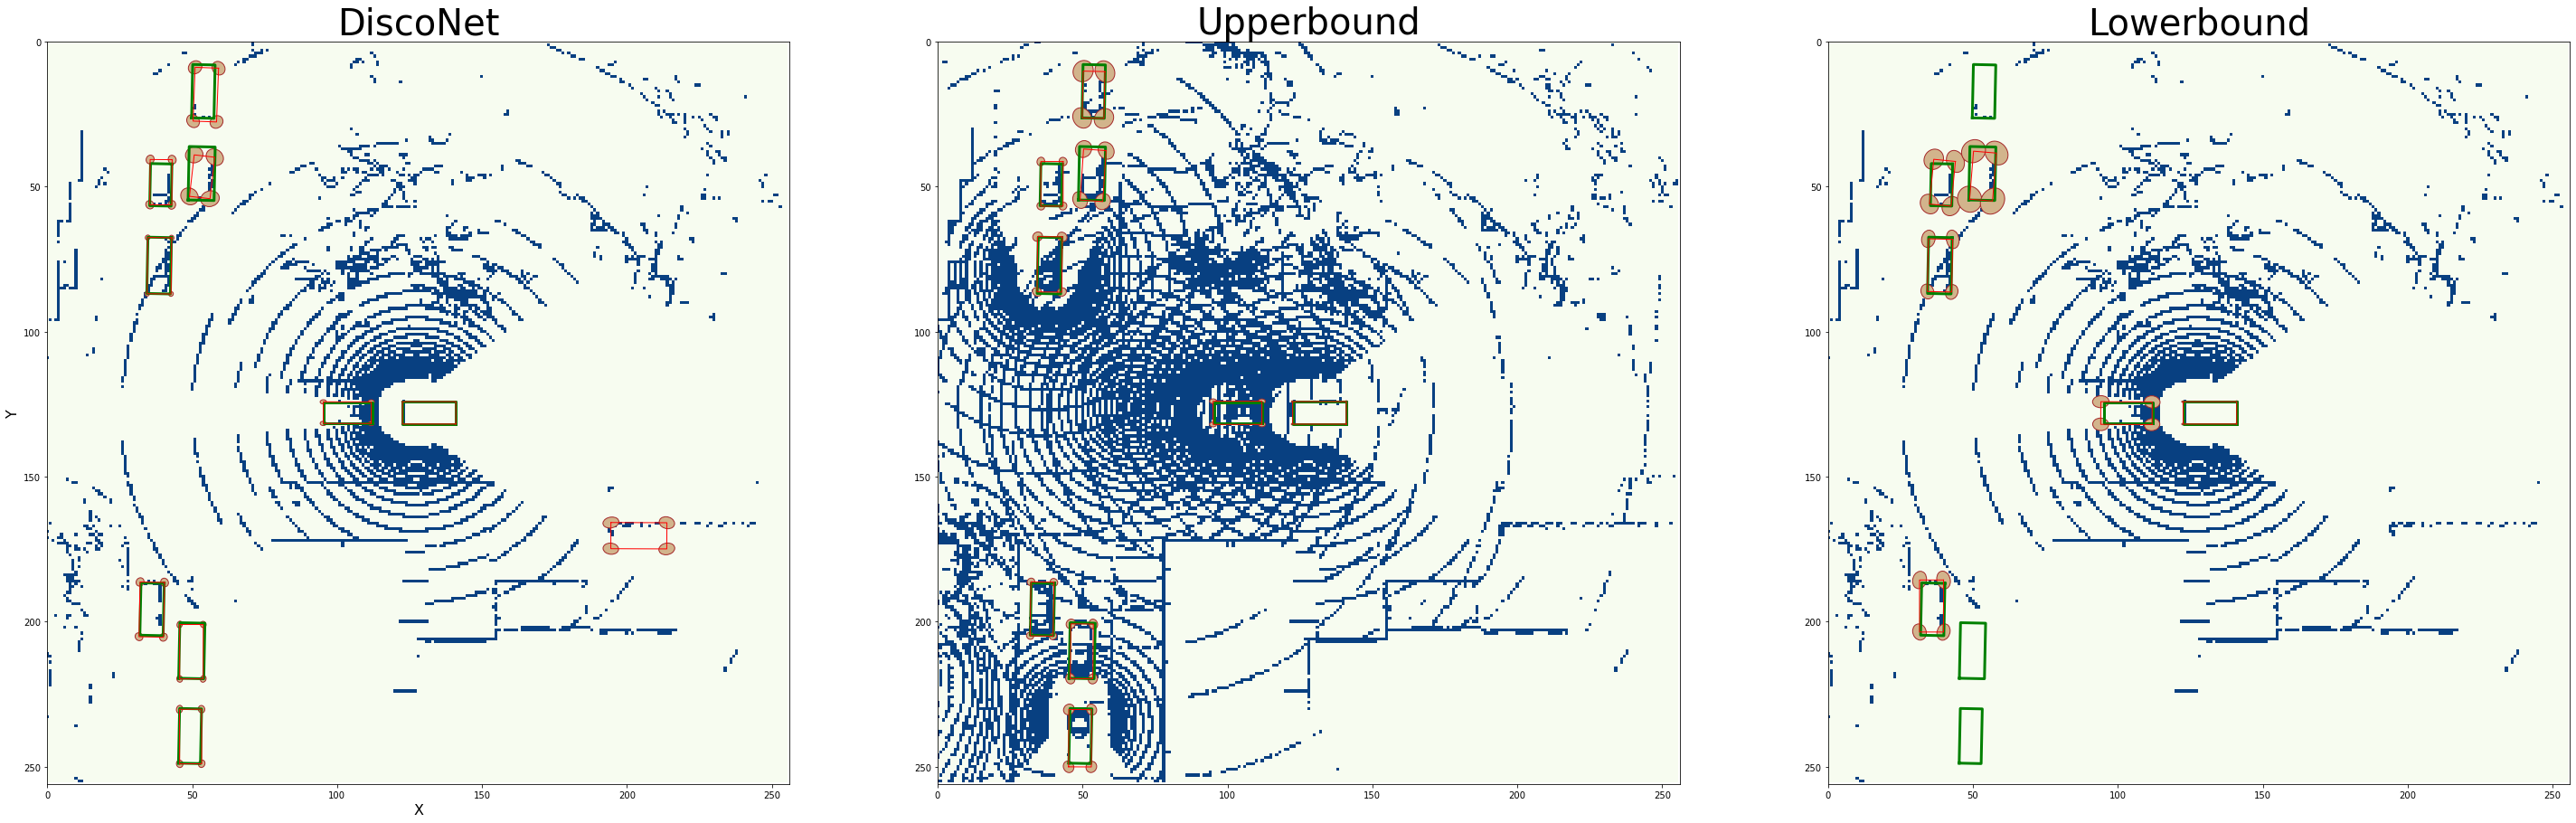

In [3]:
plot_results(1, 5, 20)

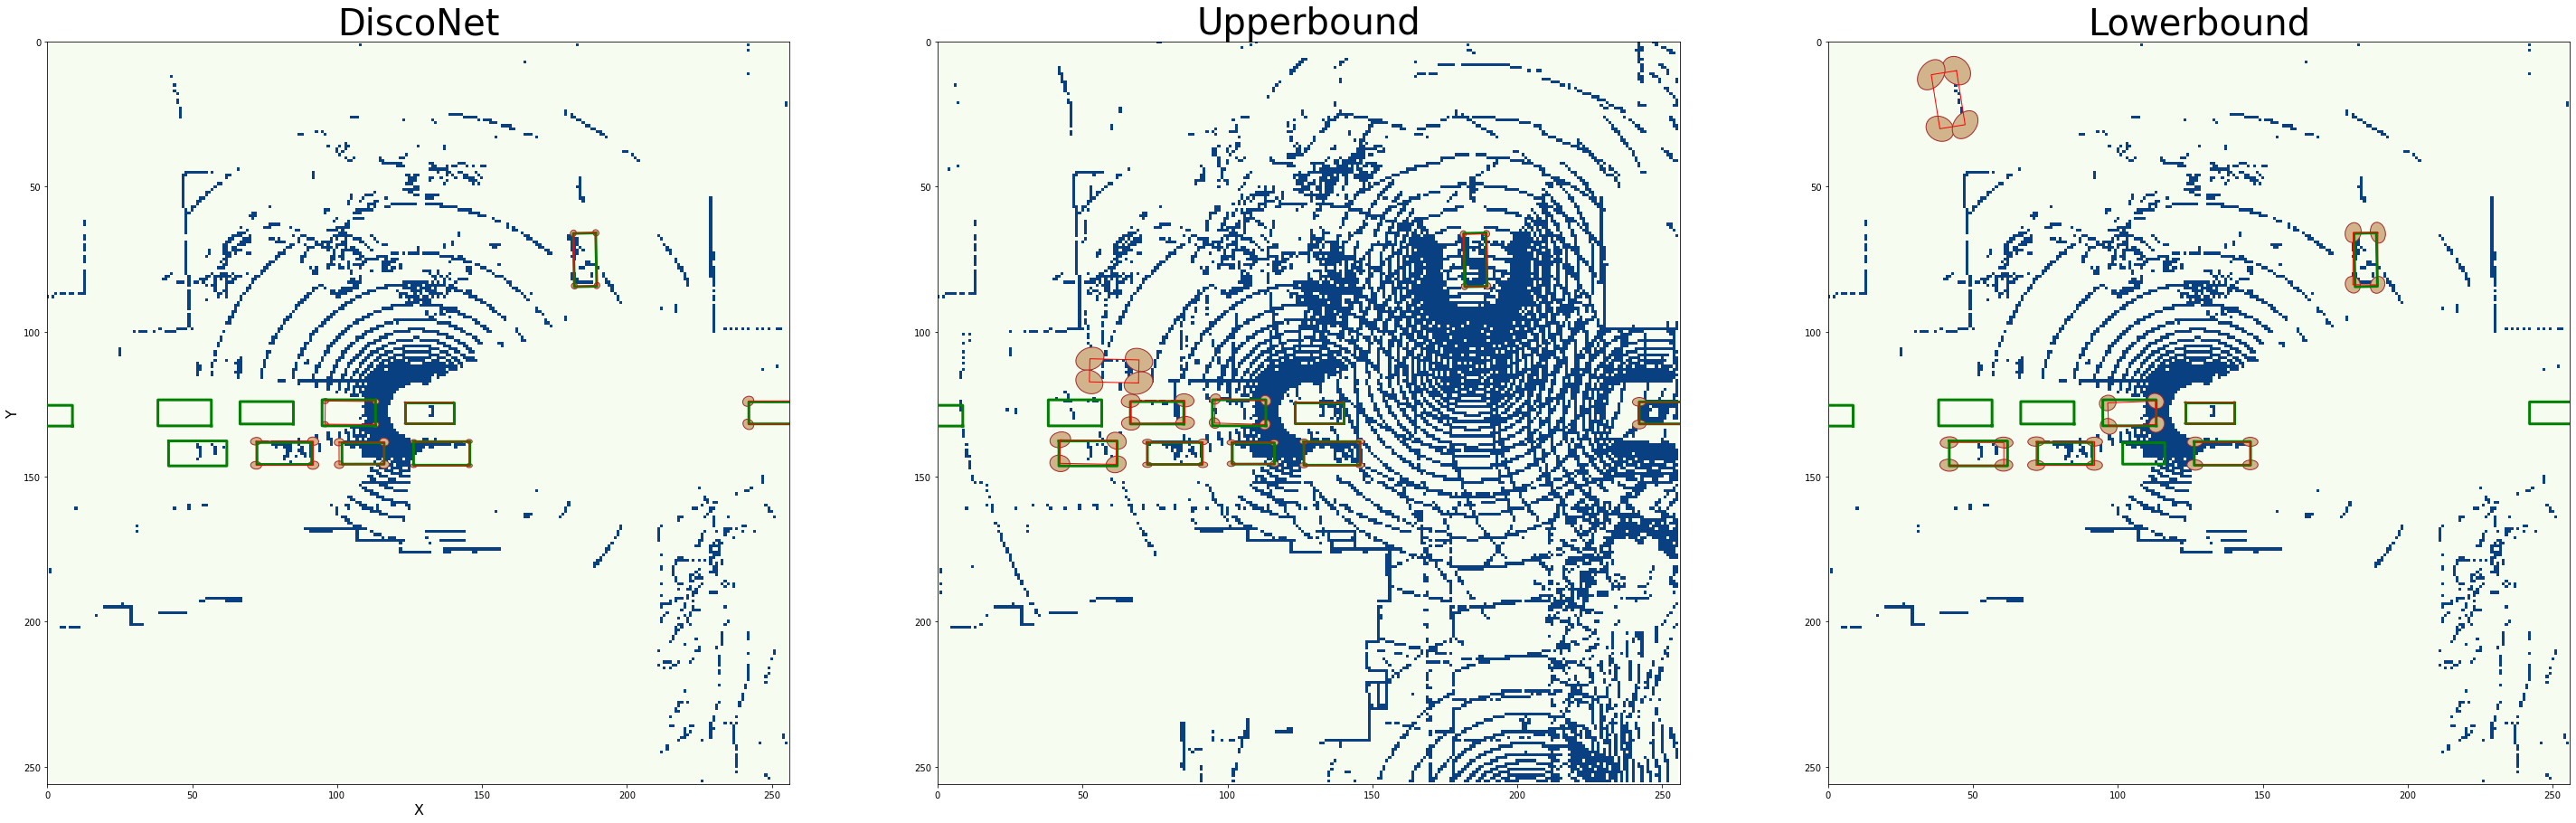

In [4]:
plot_results(1, 8, 70)

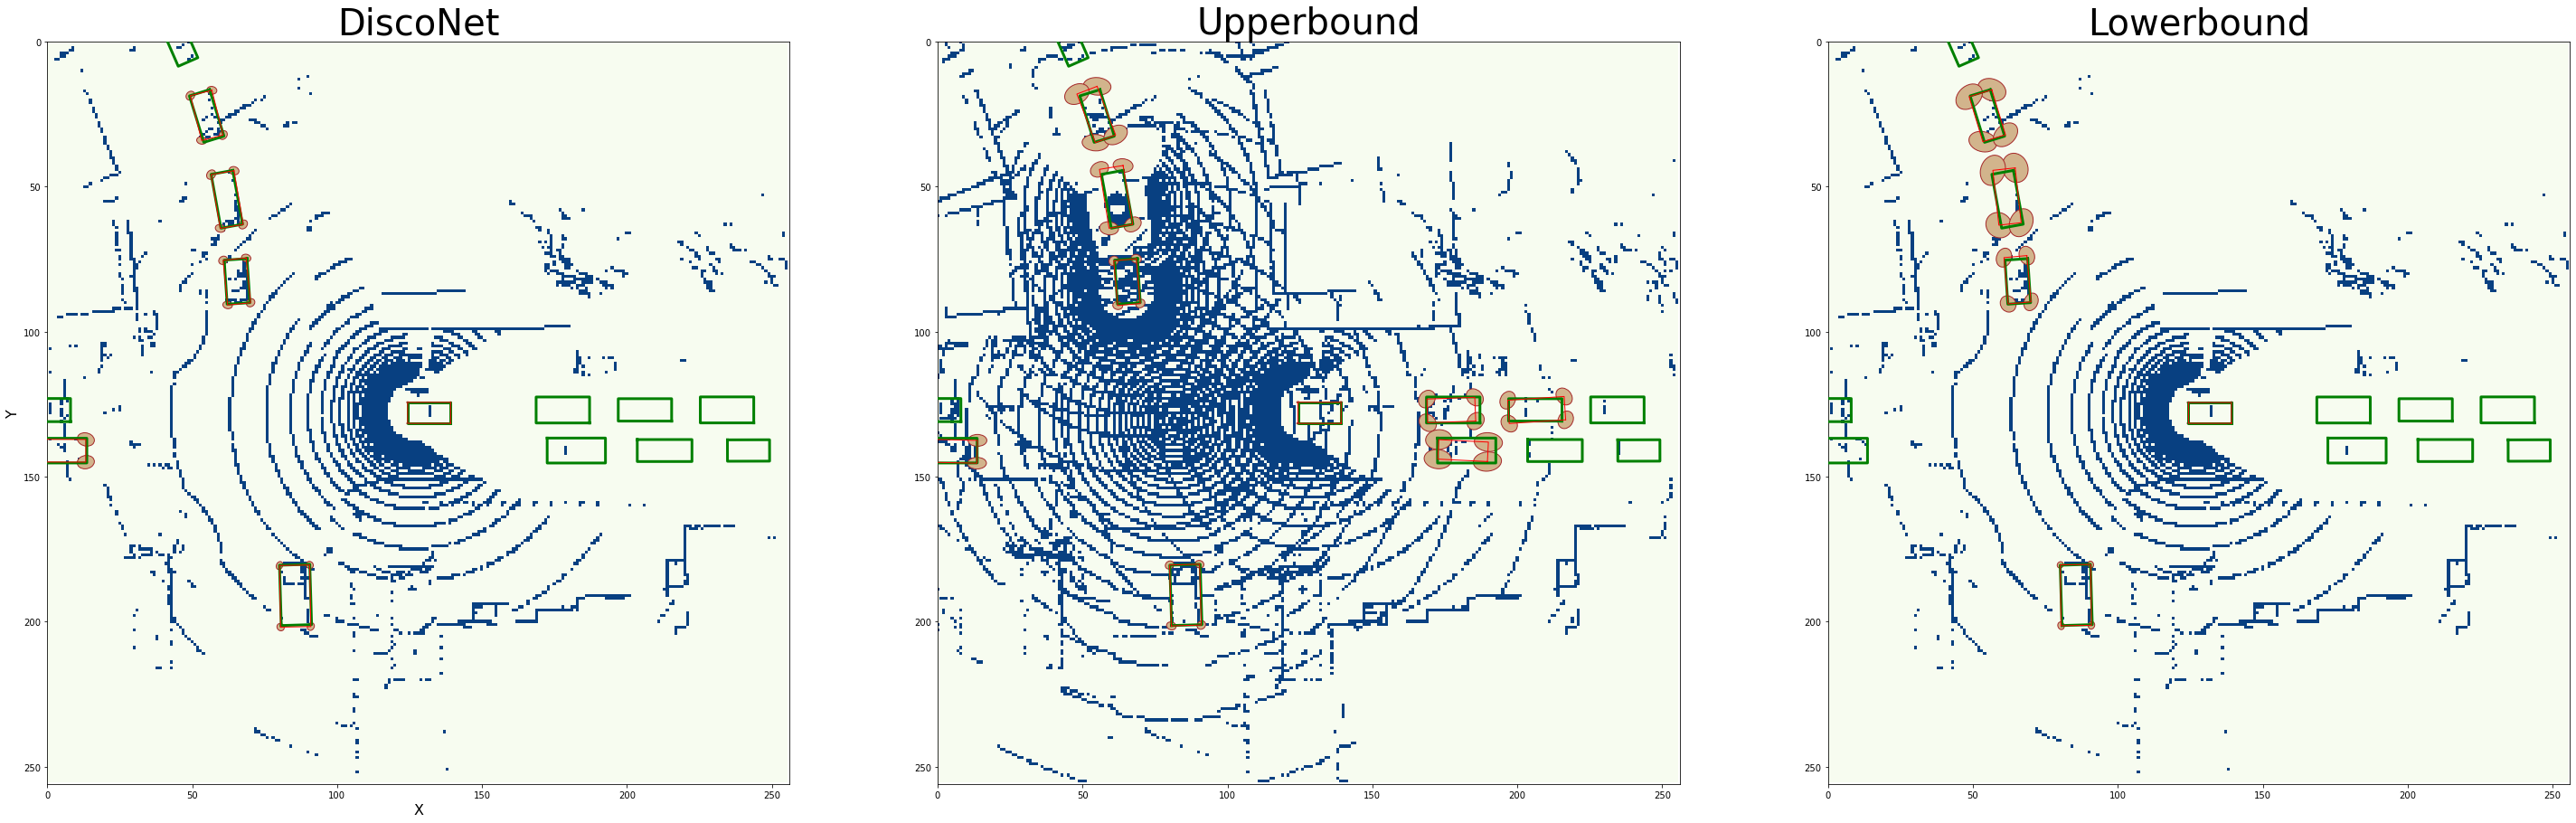

In [5]:
plot_results(1, 19, 50)

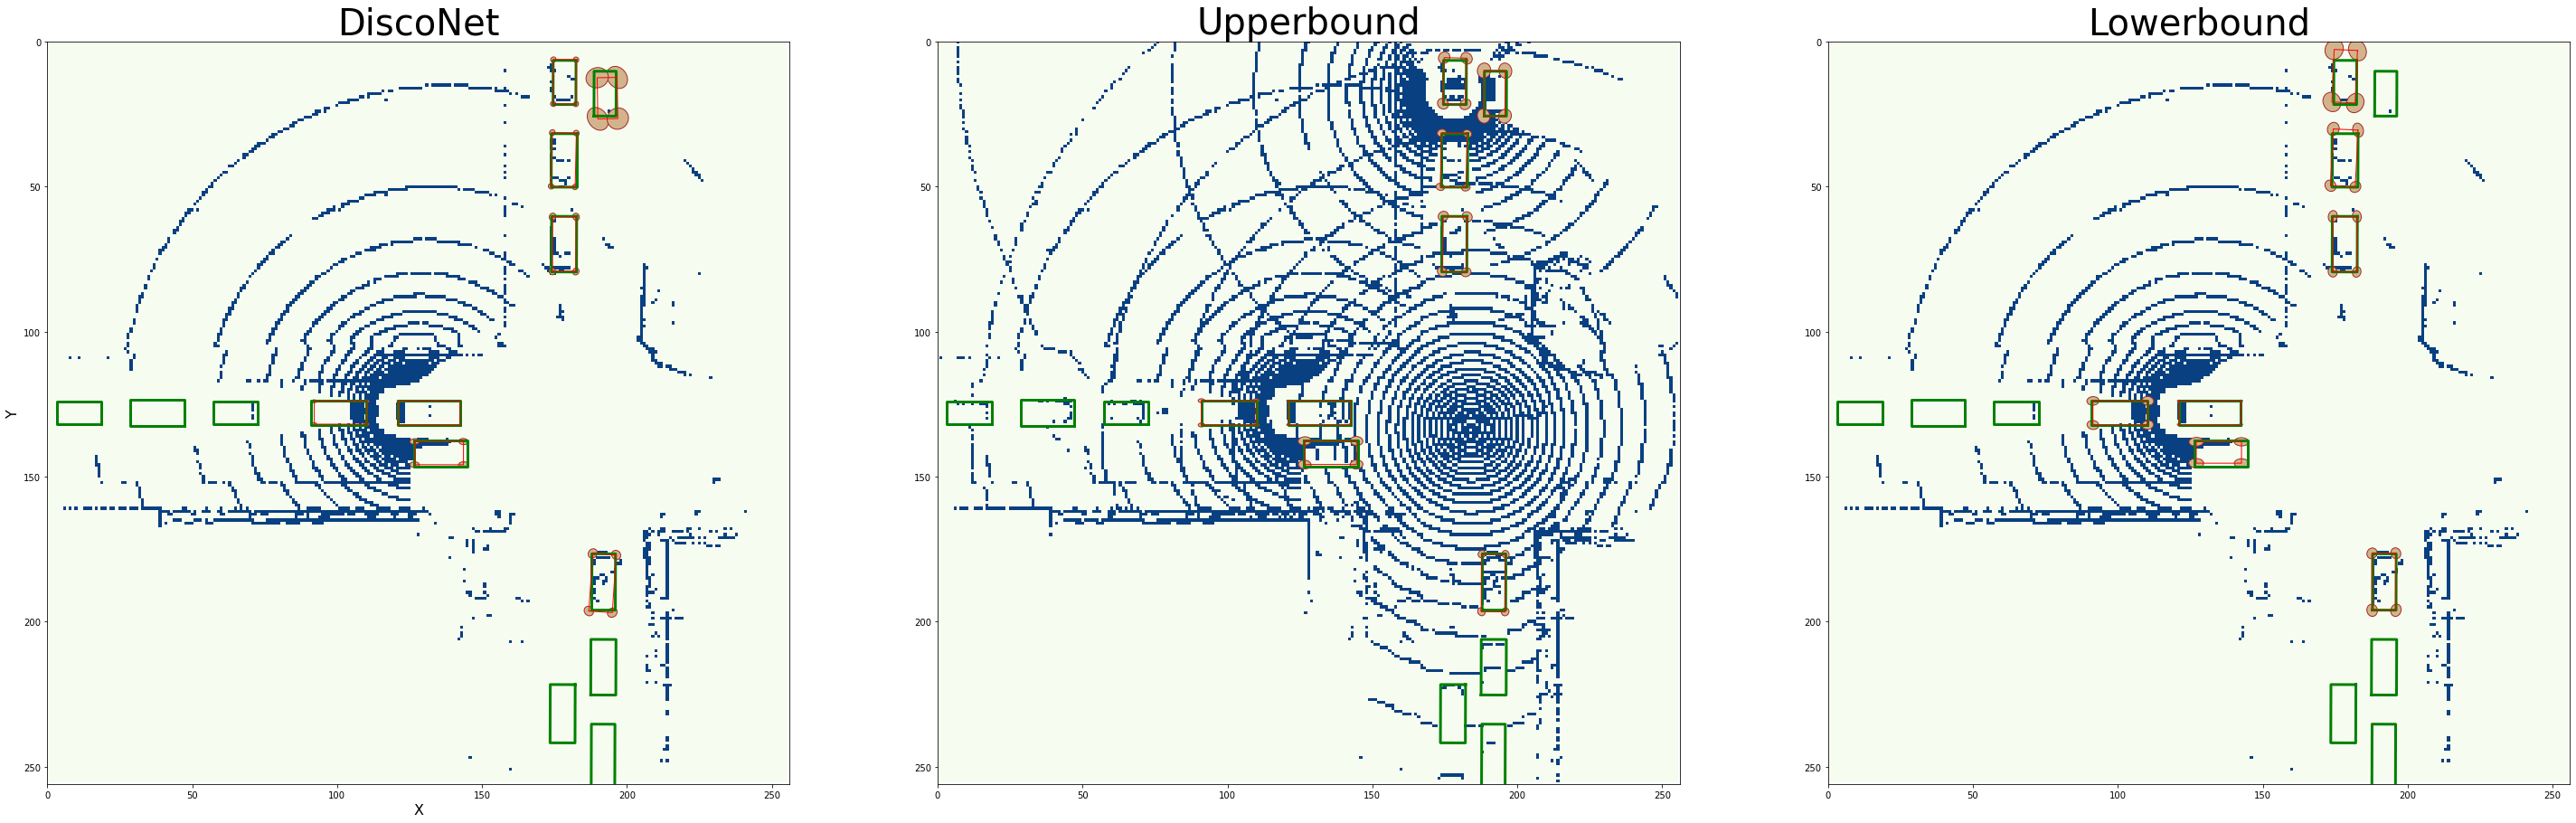

In [6]:
plot_results(1, 29, 20)

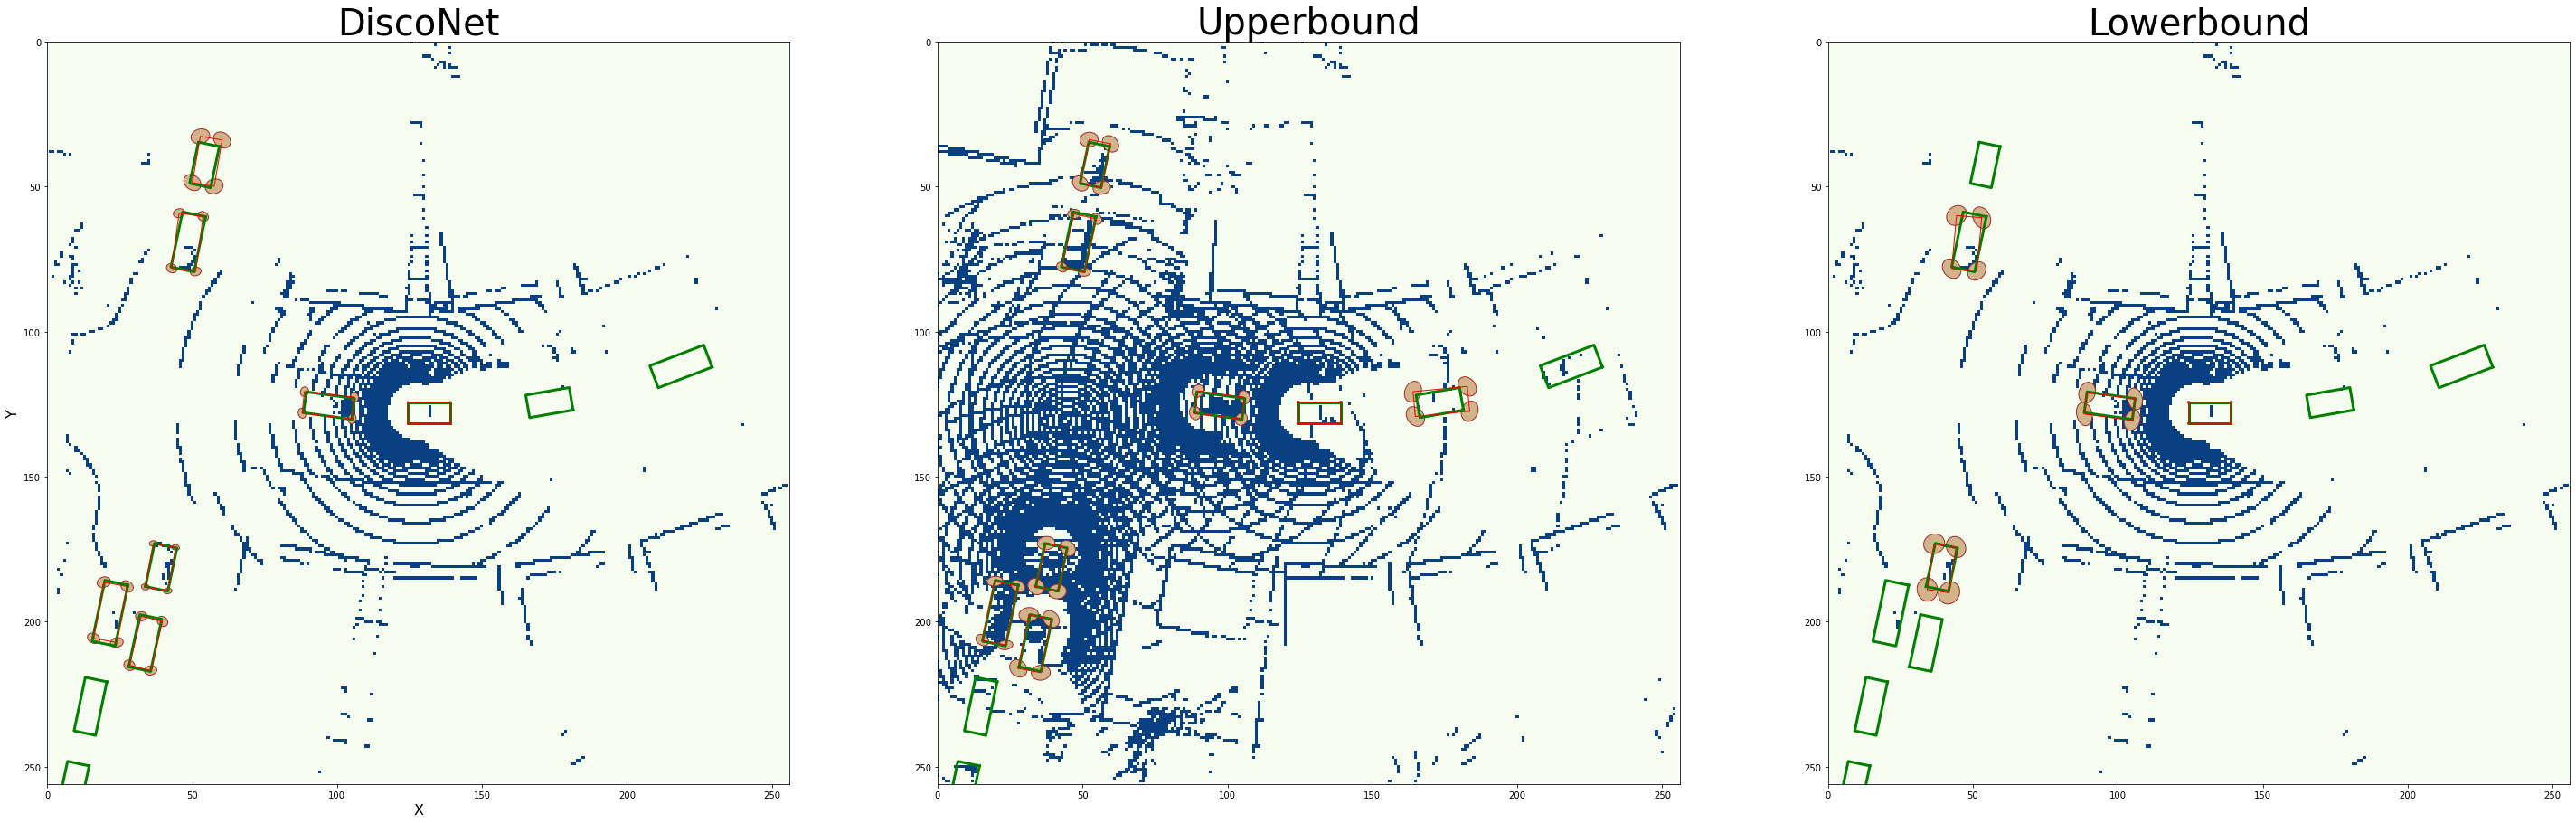

In [7]:
plot_results(1, 91, 88)

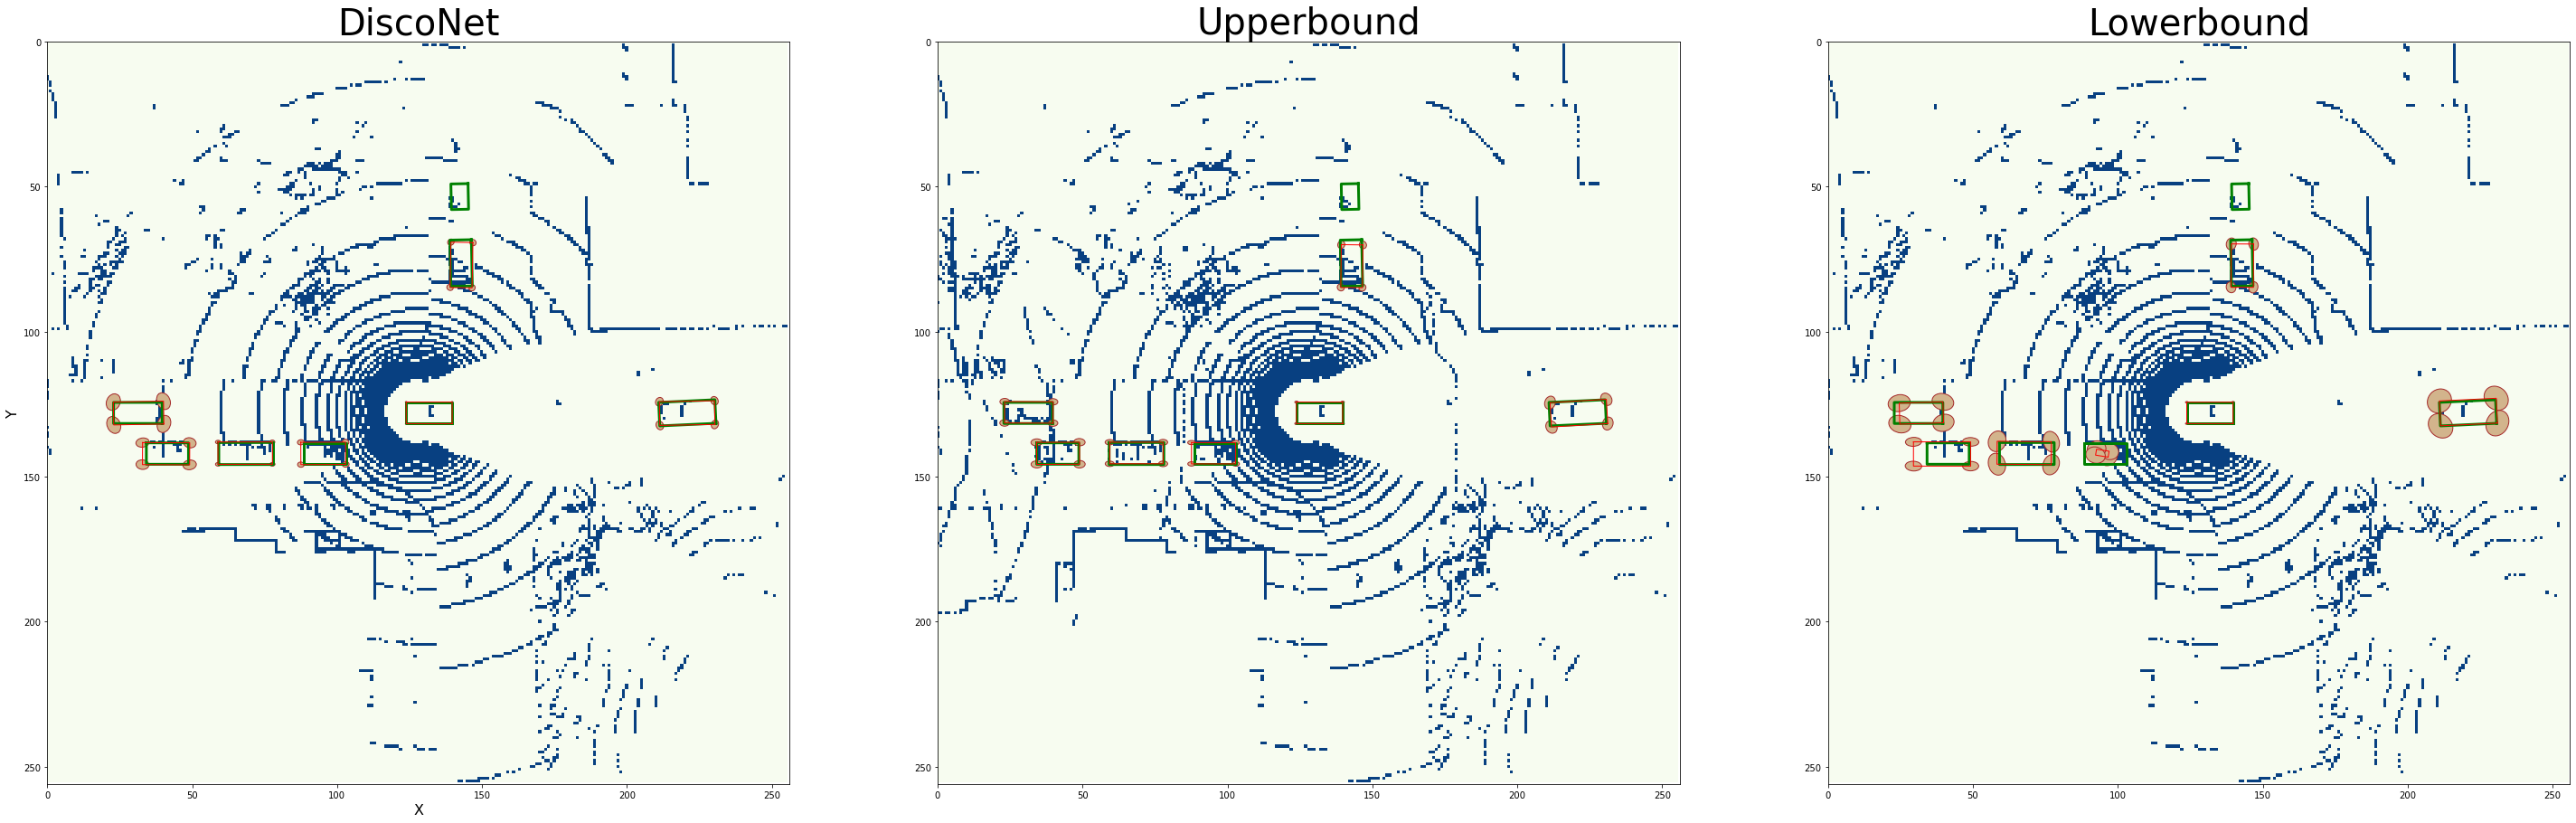

In [8]:
plot_results(1, 92, 77)

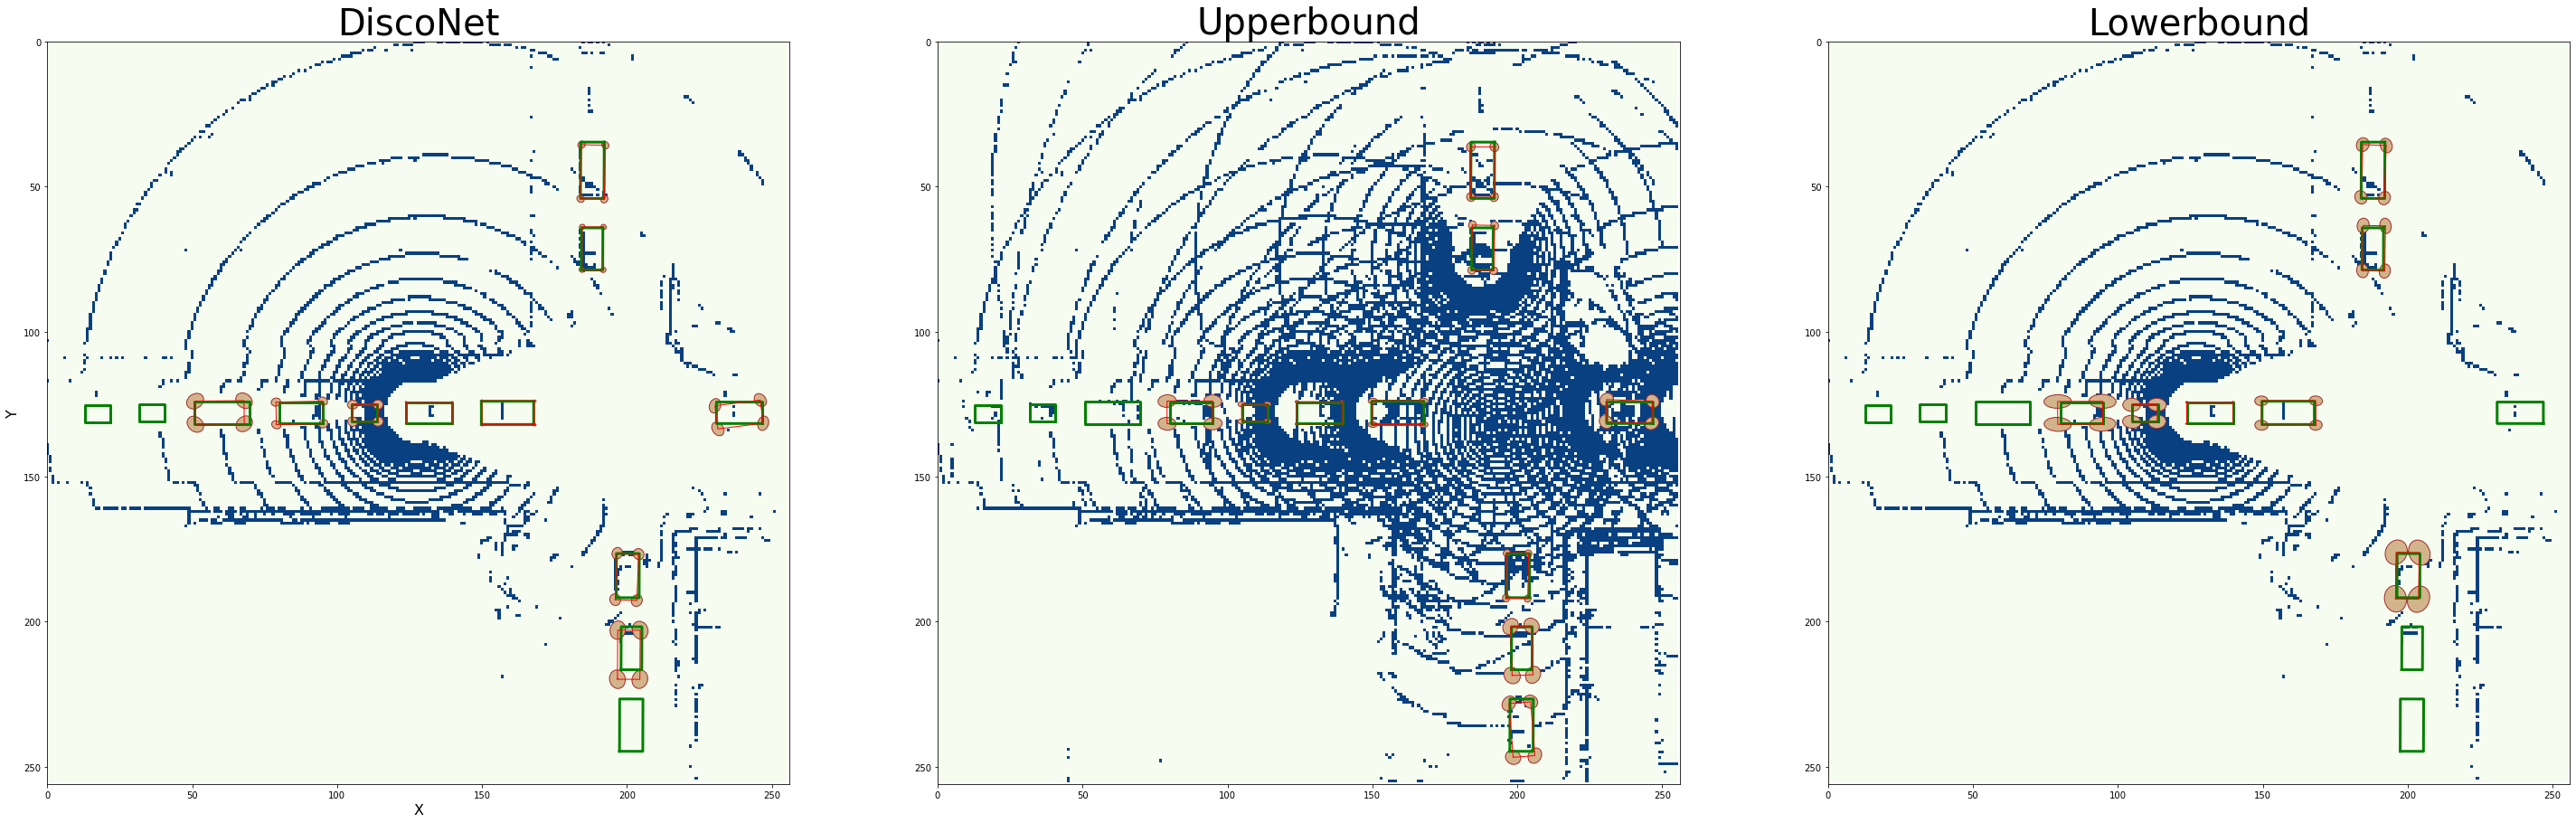

In [9]:
plot_results(1, 96, 66)

# New

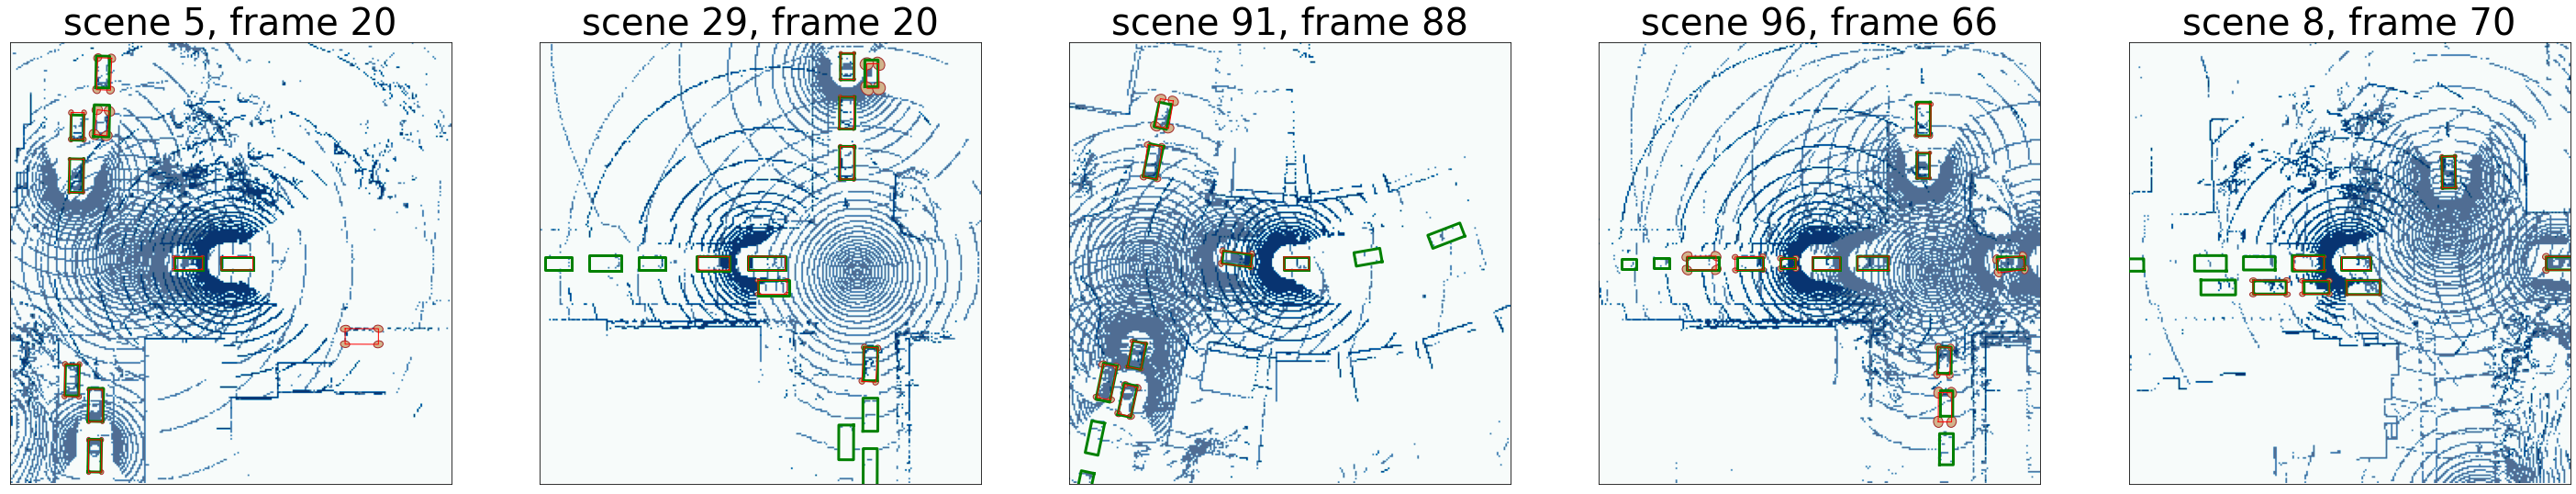

In [13]:
def plot_results(agent, scene, frame):
    fig, axes = plt.subplots(1, 5, figsize=(50, 50))
    ax = axes.ravel()

    # ax[0].set_title('Original picture')
    # ax[0].imshow(image, cmap=plt.cm.gray)
    # ax[0].set_axis_off()

    # ax[1].set_title('Transformed picture')
    # # ax[1].imshow(chull, cmap=plt.cm.viridis) 
    # ax[1].imshow(chull, cmap=plt.cm.viridis)
    # ax[1].set_axis_off()
    
    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(5) + "_" + str(20)+ "/0.npy", allow_pickle=True).item()
    # print(gt_dict)
    indices = gt_dict["voxel_indices_0"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)
    
    indices_teacher = gt_dict["voxel_indices_teacher"]
    padded_voxel_points_teacher = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points_teacher[indices_teacher[:, 0], indices_teacher[:, 1], indices_teacher[:, 2]] = 1
    padded_voxel_points_teacher = np.rot90(padded_voxel_points_teacher, 3)
    padded_voxel_points_teacher = padded_voxel_points_teacher.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/disco_all/disco_dm/result"+ str(1)  + "/" + str(5) + "_" + str(20) +".npy", allow_pickle=True).item()
    cmap = 'GnBu'
    vis(ax[0], box, 2, padded_voxel_points, padded_voxel_points_teacher, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(29) + "_" + str(20)+ "/0.npy", allow_pickle=True).item()
    indices = gt_dict["voxel_indices_0"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)
    
    indices_teacher = gt_dict["voxel_indices_teacher"]
    padded_voxel_points_teacher = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points_teacher[indices_teacher[:, 0], indices_teacher[:, 1], indices_teacher[:, 2]] = 1
    padded_voxel_points_teacher = np.rot90(padded_voxel_points_teacher, 3)
    padded_voxel_points_teacher = padded_voxel_points_teacher.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/disco_all/disco_dm/result"+ str(1)  + "/" + str(29) + "_" + str(20) +".npy", allow_pickle=True).item()

    cmap = 'GnBu'
    # cmap = "PuBuGn"
    vis(ax[1], box, 2, padded_voxel_points, padded_voxel_points_teacher, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(91) + "_" + str(88)+ "/0.npy", allow_pickle=True).item()
    indices = gt_dict["voxel_indices_0"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)
    
    indices_teacher = gt_dict["voxel_indices_teacher"]
    padded_voxel_points_teacher = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points_teacher[indices_teacher[:, 0], indices_teacher[:, 1], indices_teacher[:, 2]] = 1
    padded_voxel_points_teacher = np.rot90(padded_voxel_points_teacher, 3)
    padded_voxel_points_teacher = padded_voxel_points_teacher.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/disco_all/disco_dm/result"+ str(1)  + "/" + str(91) + "_" + str(88) +".npy", allow_pickle=True).item()
    cmap = 'GnBu'
    vis(ax[2], box, 2, padded_voxel_points, padded_voxel_points_teacher, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(96) + "_" + str(66)+ "/0.npy", allow_pickle=True).item()
    indices = gt_dict["voxel_indices_0"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)
    
    indices_teacher = gt_dict["voxel_indices_teacher"]
    padded_voxel_points_teacher = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points_teacher[indices_teacher[:, 0], indices_teacher[:, 1], indices_teacher[:, 2]] = 1
    padded_voxel_points_teacher = np.rot90(padded_voxel_points_teacher, 3)
    padded_voxel_points_teacher = padded_voxel_points_teacher.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/disco_all/disco_dm/result"+ str(1)  + "/" + str(96) + "_" + str(66) +".npy", allow_pickle=True).item()
    cmap = 'GnBu'
    vis(ax[3], box, 2, padded_voxel_points, padded_voxel_points_teacher, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(8) + "_" + str(70)+ "/0.npy", allow_pickle=True).item()
    indices = gt_dict["voxel_indices_0"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)
    
    indices_teacher = gt_dict["voxel_indices_teacher"]
    padded_voxel_points_teacher = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points_teacher[indices_teacher[:, 0], indices_teacher[:, 1], indices_teacher[:, 2]] = 1
    padded_voxel_points_teacher = np.rot90(padded_voxel_points_teacher, 3)
    padded_voxel_points_teacher = padded_voxel_points_teacher.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/disco_all/disco_dm/result"+ str(1)  + "/" + str(8) + "_" + str(70) +".npy", allow_pickle=True).item()
    cmap = 'GnBu'
    vis(ax[4], box, 2, padded_voxel_points, padded_voxel_points_teacher, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    
    ax[0].set_title('scene 5, frame 20', fontsize=40)
    ax[1].set_title('scene 29, frame 20', fontsize=40)
    ax[2].set_title('scene 91, frame 88', fontsize=40)
    ax[3].set_title('scene 96, frame 66', fontsize=40)
    ax[4].set_title('scene 8, frame 70', fontsize=40)
    
    
    ax[0].set_xlim(0,256)
    ax[1].set_xlim(0,256)
    ax[2].set_xlim(0,256)
    ax[3].set_xlim(0,256)
    ax[4].set_xlim(0,256)
    
    ax[0].set_ylim(256,0)
    ax[1].set_ylim(256,0)
    ax[2].set_ylim(256,0)
    ax[3].set_ylim(256,0)
    ax[4].set_ylim(256,0)
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    ax[4].set_xticks([])
    ax[4].set_yticks([])

    
    plt.savefig('./exp_disco.svg',bbox_inches='tight')
    
plot_results(0,0,0)

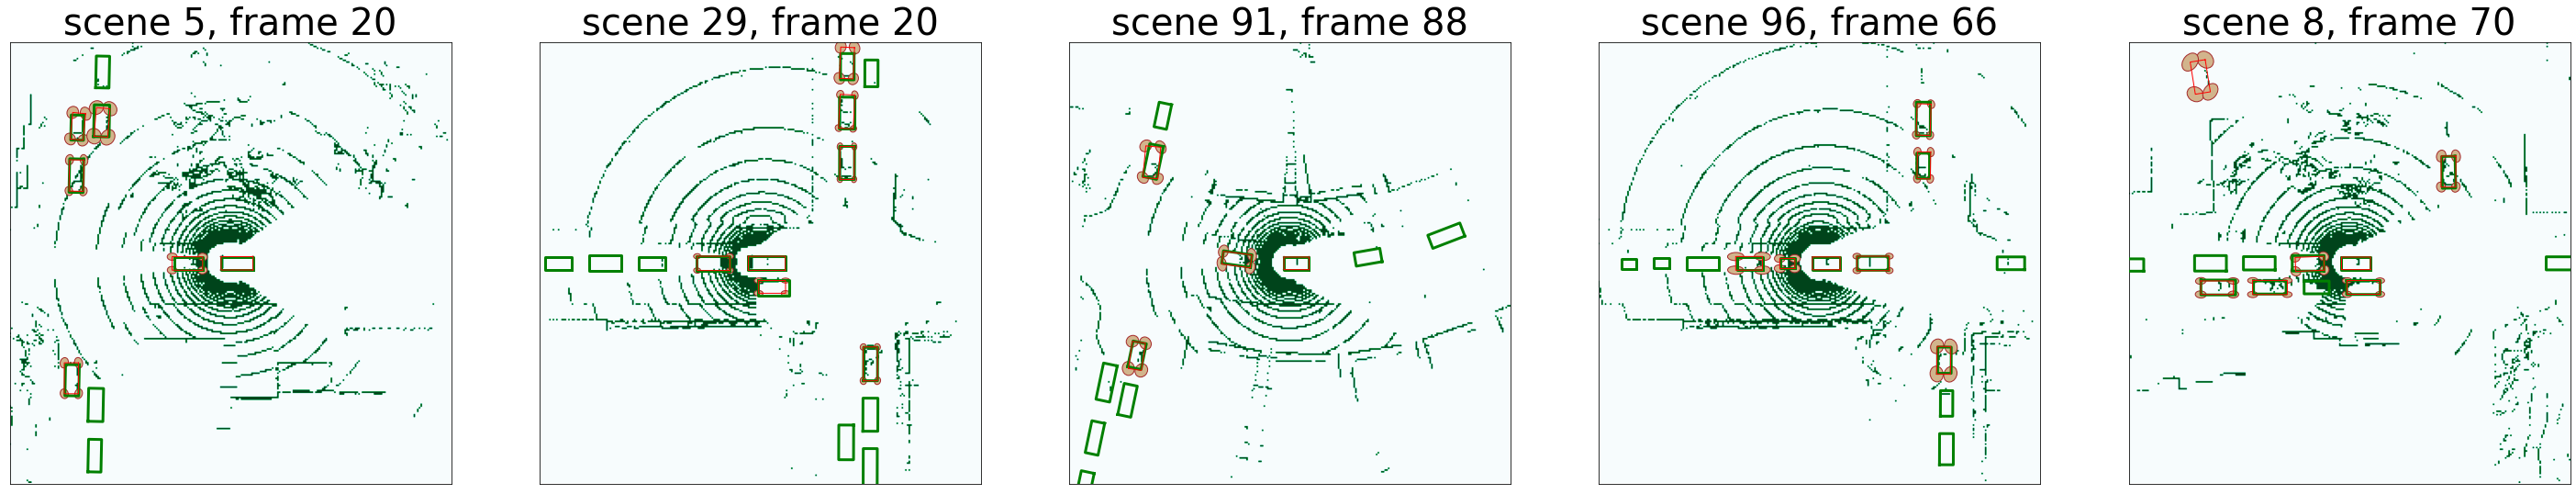

In [8]:
def plot_results(agent, scene, frame):
    fig, axes = plt.subplots(1, 5, figsize=(50, 50))
    ax = axes.ravel()

    # ax[0].set_title('Original picture')
    # ax[0].imshow(image, cmap=plt.cm.gray)
    # ax[0].set_axis_off()

    # ax[1].set_title('Transformed picture')
    # # ax[1].imshow(chull, cmap=plt.cm.viridis) 
    # ax[1].imshow(chull, cmap=plt.cm.viridis)
    # ax[1].set_axis_off()
    
    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(5) + "_" + str(20)+ "/0.npy", allow_pickle=True).item()
    # print(gt_dict)
    indices = gt_dict["voxel_indices_0"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/lowerbound_all/lowerbound_dm/result"+ str(1)  + "/" + str(5) + "_" + str(20) +".npy", allow_pickle=True).item()
    cmap = 'BuGn'
    vis(ax[0], box, 2, padded_voxel_points, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(29) + "_" + str(20)+ "/0.npy", allow_pickle=True).item()
    indices = gt_dict["voxel_indices_0"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/lowerbound_all/lowerbound_dm/result"+ str(1)  + "/" + str(29) + "_" + str(20) +".npy", allow_pickle=True).item()

    cmap = 'BuGn'
    vis(ax[1], box, 2, padded_voxel_points, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(91) + "_" + str(88)+ "/0.npy", allow_pickle=True).item()
    indices = gt_dict["voxel_indices_0"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/lowerbound_all/lowerbound_dm/result"+ str(1)  + "/" + str(91) + "_" + str(88) +".npy", allow_pickle=True).item()
    cmap = 'BuGn'
    vis(ax[2], box, 2, padded_voxel_points, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(96) + "_" + str(66)+ "/0.npy", allow_pickle=True).item()
    indices = gt_dict["voxel_indices_0"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/lowerbound_all/lowerbound_dm/result"+ str(1)  + "/" + str(96) + "_" + str(66) +".npy", allow_pickle=True).item()
    cmap = 'BuGn'
    vis(ax[3], box, 2, padded_voxel_points, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(8) + "_" + str(70)+ "/0.npy", allow_pickle=True).item()
    indices = gt_dict["voxel_indices_0"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/lowerbound_all/lowerbound_dm/result"+ str(1)  + "/" + str(8) + "_" + str(70) +".npy", allow_pickle=True).item()
    cmap = 'BuGn'
    vis(ax[4], box, 2, padded_voxel_points, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    
    ax[0].set_title('scene 5, frame 20', fontsize=40)
    ax[1].set_title('scene 29, frame 20', fontsize=40)
    ax[2].set_title('scene 91, frame 88', fontsize=40)
    ax[3].set_title('scene 96, frame 66', fontsize=40)
    ax[4].set_title('scene 8, frame 70', fontsize=40)
    
    
    ax[0].set_xlim(0,256)
    ax[1].set_xlim(0,256)
    ax[2].set_xlim(0,256)
    ax[3].set_xlim(0,256)
    ax[4].set_xlim(0,256)
    
    ax[0].set_ylim(256,0)
    ax[1].set_ylim(256,0)
    ax[2].set_ylim(256,0)
    ax[3].set_ylim(256,0)
    ax[4].set_ylim(256,0)
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    
    plt.savefig('./exp_lowerbound.svg',bbox_inches='tight')
    
plot_results(0,0,0)

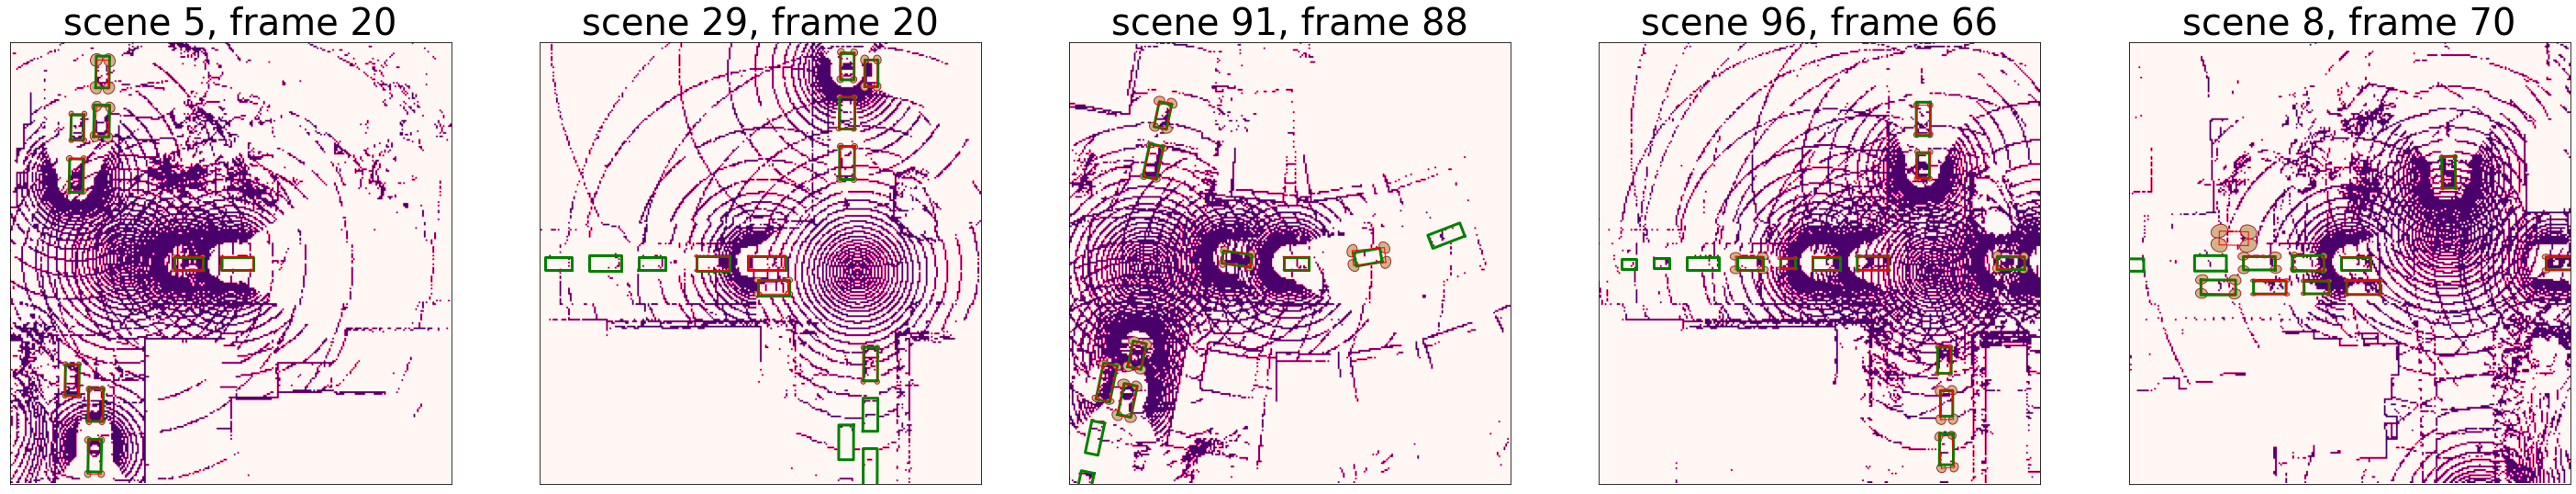

In [10]:
def plot_results(agent, scene, frame):
    fig, axes = plt.subplots(1, 5, figsize=(50, 50))
    ax = axes.ravel()

    # ax[0].set_title('Original picture')
    # ax[0].imshow(image, cmap=plt.cm.gray)
    # ax[0].set_axis_off()

    # ax[1].set_title('Transformed picture')
    # # ax[1].imshow(chull, cmap=plt.cm.viridis) 
    # ax[1].imshow(chull, cmap=plt.cm.viridis)
    # ax[1].set_axis_off()
    
    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(5) + "_" + str(20)+ "/0.npy", allow_pickle=True).item()
    # print(gt_dict)
    indices = gt_dict["voxel_indices_teacher"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/upperbound_all/upperbound_dm/result"+ str(1)  + "/" + str(5) + "_" + str(20) +".npy", allow_pickle=True).item()
    cmap = 'RdPu'
    vis(ax[0], box, 2, padded_voxel_points, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(29) + "_" + str(20)+ "/0.npy", allow_pickle=True).item()
    indices = gt_dict["voxel_indices_teacher"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/upperbound_all/upperbound_dm/result"+ str(1)  + "/" + str(29) + "_" + str(20) +".npy", allow_pickle=True).item()

    vis(ax[1], box, 2, padded_voxel_points, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(91) + "_" + str(88)+ "/0.npy", allow_pickle=True).item()
    indices = gt_dict["voxel_indices_teacher"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/upperbound_all/upperbound_dm/result"+ str(1)  + "/" + str(91) + "_" + str(88) +".npy", allow_pickle=True).item()

    vis(ax[2], box, 2, padded_voxel_points, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(96) + "_" + str(66)+ "/0.npy", allow_pickle=True).item()
    indices = gt_dict["voxel_indices_teacher"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/upperbound_all/upperbound_dm/result"+ str(1)  + "/" + str(96) + "_" + str(66) +".npy", allow_pickle=True).item()

    vis(ax[3], box, 2, padded_voxel_points, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    
    gt_dict = np.load("/home/yml/Downloads/test/agent" + str(1) + "/" + str(8) + "_" + str(70)+ "/0.npy", allow_pickle=True).item()
    indices = gt_dict["voxel_indices_teacher"]
    padded_voxel_points = np.zeros((256,256,13), dtype=bool)
    padded_voxel_points[indices[:, 0], indices[:, 1], indices[:, 2]] = 1
    padded_voxel_points = np.rot90(padded_voxel_points, 3)
    padded_voxel_points = padded_voxel_points.astype(np.float32)

    # specify the result path
    box = np.load("/home/yml/Downloads/upperbound_all/upperbound_dm/result"+ str(1)  + "/" + str(8) + "_" + str(70) +".npy", allow_pickle=True).item()

    vis(ax[4], box, 2, padded_voxel_points, cmap)

    # ---------------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------------
    ax[0].set_title('scene 5, frame 20', fontsize=40)
    ax[1].set_title('scene 29, frame 20', fontsize=40)
    ax[2].set_title('scene 91, frame 88', fontsize=40)
    ax[3].set_title('scene 96, frame 66', fontsize=40)
    ax[4].set_title('scene 8, frame 70', fontsize=40)
    
    
    ax[0].set_xlim(0,256)
    ax[1].set_xlim(0,256)
    ax[2].set_xlim(0,256)
    ax[3].set_xlim(0,256)
    ax[4].set_xlim(0,256)
    
    ax[0].set_ylim(256,0)
    ax[1].set_ylim(256,0)
    ax[2].set_ylim(256,0)
    ax[3].set_ylim(256,0)
    ax[4].set_ylim(256,0)
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    
    plt.savefig('./exp_upperbound.svg',bbox_inches='tight')
    
plot_results(0,0,0)